In [155]:
import numpy as np
import qutip as qutip
import time as time

from matplotlib import pyplot as plt

import sys
import os
sys.path.append('../../utils')

from tomography import coherent_state_tomography as cst
from tomography import coherent_state_tomography_copy as cst2
from visualization import state_visualization as state_vis
from math_utils import statistics_utils as su
from quantum_utils import quantum_optics_utils as qou

import numpy as np
import scipy as sp
import scipy.fftpack
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
from functools import partial
from scipy.signal import butter, filtfilt, freqz, lfilter
from scipy.signal import kaiserord, lfilter, firwin, freqz
from pylab import *
import scipy.signal as signal
import scipy.special as spy
π = np.pi; pi = np.pi
from scipy.signal import savgol_filter
import copy
import qutip
from mpl_toolkits.mplot3d import Axes3D

In [6]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


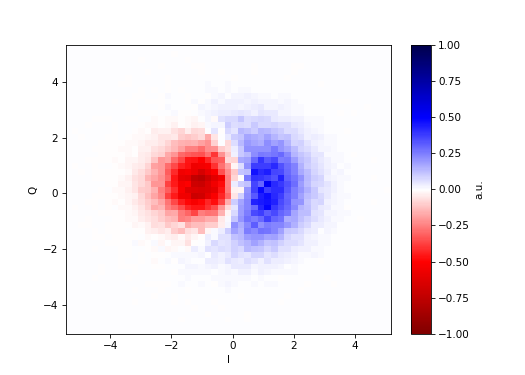

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


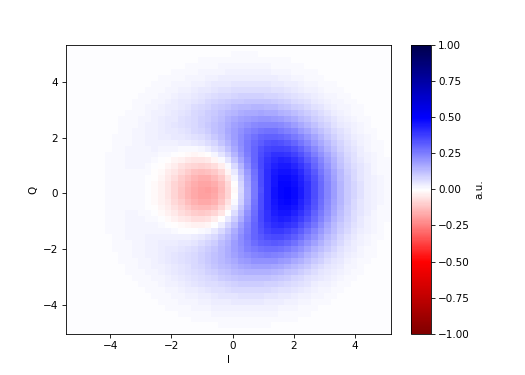

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


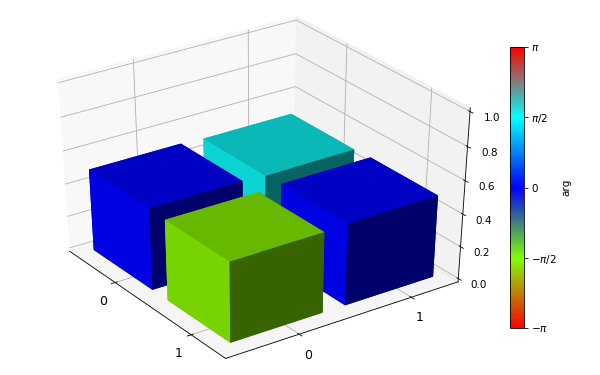

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


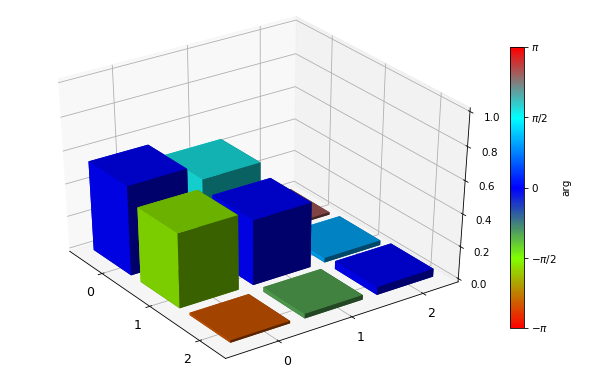

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 0.54932839+0.j         -0.06231766+0.45486702j -0.01227954+0.00765347j]
 [-0.06231766-0.45486702j  0.40134322+0.j          0.0140217 +0.02470249j]
 [-0.01227954-0.00765347j  0.0140217 -0.02470249j  0.04932839+0.j        ]]

In [248]:
f_real = open(os.path.join(path, 'Q3_278.22mV_field_singleshot_1.5pi_5times_real.txt'))
f_imag = open(os.path.join(path, 'Q3_278.22mV_field_singleshot_1.5pi_5times_imag.txt'))
data_real = f_real.readlines()
data_imag = f_imag.readlines()
data_real_all = np.array( [np.array([float(val) for val in data_real[i].split('\t')]) for i in range(4,9)]).flatten()
data_imag_all = np.array( [np.array([float(val) for val in data_imag[i].split('\t')]) for i in range(4,9)]).flatten()
shots_all_p1 = (data_real_all*1j + data_imag_all)
f_real.close(); f_imag.close()

f_real = open(os.path.join(path, 'Q3_278.22mV_field_singleshot_1.5pi_5times_real_dark.txt'))
f_imag = open(os.path.join(path, 'Q3_278.22mV_field_singleshot_1.5pi_5times_imag_dark.txt'))
data_real = f_real.readlines()
data_imag = f_imag.readlines()
data_real_all = np.array( [np.array([float(val) for val in data_real[i].split('\t')]) for i in range(4,9)]).flatten()
data_imag_all = np.array( [np.array([float(val) for val in data_imag[i].split('\t')]) for i in range(4,9)]).flatten()
shots_all_dark = (data_real_all*1j + data_imag_all)
f_real.close(); f_imag.close()

hist_2D_p1 = np.histogram2d(np.real(shots_all_p1), np.imag(shots_all_p1), bins = 50, density = True)
hist_2D_dark = np.histogram2d(np.imag(shots_all_dark), np.real(shots_all_dark), 
                                 range = [[hist_2D_p1[1][0], hist_2D_p1[1][-1]], [hist_2D_p1[2][0], hist_2D_p1[2][-1]]],
                                 bins = 50, density = True)
#dI_dQ = (hist_2D_p1[1][0] - hist_2D_p1[1][-1])*(hist_2D_p1[2][0] - hist_2D_p1[2][-1])/2500

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)
xx, yy = np.meshgrid(hist_2D_p1[1][:-1], hist_2D_p1[2][:-1])
pcolor = ax.pcolormesh(xx, yy, (hist_2D_p1[0] - hist_2D_dark[0])/dI_dQ, cmap='seismic_r')
fig.colorbar(pcolor, ax=ax, aspect = 15, label = "a.u.")
ax.set_xlabel('I'); ax.set_ylabel('Q') 
pcolor.set_clim(-1,1)

#psi = Qobj(np.array([[0, 0], [0,1]]))
psi = (qutip.basis(2,0) + qutip.basis(2,1)).unit()
wigner_sim = qutip.wigner(psi, hist_2D_p1[1][:-1], hist_2D_p1[2][:-1], g = 1/np.sqrt(2))
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)
pcolor = ax.pcolormesh(xx, yy, wigner_sim/.15, cmap='seismic_r')
fig.colorbar(pcolor, ax=ax, aspect = 15, label = "a.u.")
ax.set_xlabel('I'); ax.set_ylabel('Q') 
pcolor.set_clim(-1,1)

a = np.mean(shots_all_p1); hdag_h = np.mean(np.abs(shots_all_dark)**2); 
hdag_2_h_2 = np.mean(np.abs(shots_all_dark)**4) 
adag_a = np.mean(np.abs(shots_all_p1)**2) - hdag_h
a_2 = np.mean(shots_all_p1**2); 
adag_2_a = np.mean(np.conj(shots_all_p1)*np.abs(shots_all_p1)**2) - 2 * np.conj(a) * hdag_h
adag_2_a_2 = np.mean(np.abs(shots_all_p1)**4) - 4*adag_a*hdag_h - hdag_2_h_2

loss_scaling = 0.6665061576492075

rho = qutip.Qobj(np.array([[1 - adag_a, a], [np.conj(a), adag_a]]))
rho = (rho - (1- loss_scaling) * np.array([[1,0],[0,0]]))/loss_scaling


fig = plt.figure( figsize=(8,5) )
ax = Axes3D(fig, azim=-35, elev=35)
qutip.matrix_histogram_complex(rho, fig=fig, ax=ax) 
rho

rho_from_moments = np.zeros((3,3), dtype = complex)

rho_from_moments[0,0] = 1 - adag_a +  adag_2_a_2/2
rho_from_moments[0,1] = a - np.conj(adag_2_a)
rho_from_moments[0,2] = a_2/sqrt(2)

rho_from_moments[1,0] = np.conj(rho_from_moments[0,1])
rho_from_moments[1,1] = adag_a - adag_2_a_2
rho_from_moments[1,2] = np.conj(adag_2_a)/sqrt(2)


rho_from_moments[2,0] = np.conj(rho_from_moments[0,2])
rho_from_moments[2,1] = np.conj(rho_from_moments[1,2])
rho_from_moments[2,2] = adag_2_a_2/2

rho_from_moments = (rho_from_moments - (1- loss_scaling) * np.array([[1,0,0],[0,0,0],[0,0,0]]))/loss_scaling
fig = plt.figure( figsize=(8,5) )
ax = Axes3D(fig, azim=-35, elev=35)
qutip.matrix_histogram_complex(qutip.Qobj(rho_from_moments), fig=fig, ax=ax) 
qutip.Qobj(rho_from_moments)

../../utils/visualization/state_visualization.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)


<IPython.core.display.Javascript object>


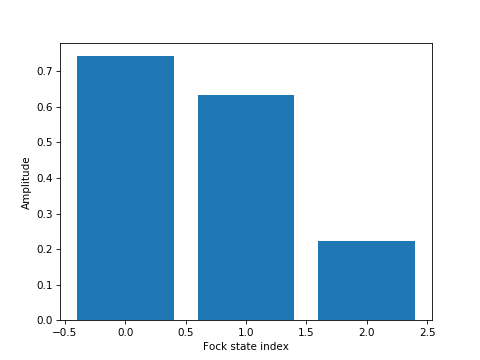

In [243]:
state_vis.plot_fock_basis_amplitudes(qutip.Qobj(rho_from_moments).unit())






In [250]:
pi = np.pi
gain_scaling = 4.0931546058599855
global_phase = np.exp(-1j*pi/25)

path = "/Users/andreas/Desktop/work/cluster_state/photon_tomography/measurement_data/"
f_real = open(os.path.join(path, 'Q3_295mV_field_avg_one_photons_calibrated_single_shot_unscaled_dark_real.txt'))
f_imag = open(os.path.join(path, 'Q3_295mV_field_avg_one_photons_calibrated_single_shot_unscaled_dark_imag.txt'))
data_real = f_real.readlines()
data_imag = f_imag.readlines()
data_real_all = np.array( [np.array([float(val) for val in data_real[i].split('\t')]) for i in range(4,19)]).flatten()
data_imag_all = np.array( [np.array([float(val) for val in data_imag[i].split('\t')]) for i in range(4,19)]).flatten()
shots_all_dark = global_phase * (data_real_all + 1j*data_imag_all)/gain_scaling
f_real.close(); f_imag.close()

f_real = open(os.path.join(path, 'Q3_295mV_field_avg_one_photons_calibrated_single_shot_unscaled_pi_half_real.txt'))
f_imag = open(os.path.join(path, 'Q3_295mV_field_avg_one_photons_calibrated_single_shot_unscaled_pi_half_imag.txt'))
data_real = f_real.readlines()
data_imag = f_imag.readlines()
data_real_all = np.array( [np.array([float(val) for val in data_real[i].split('\t')]) for i in range(4,19)]).flatten()
data_imag_all = np.array( [np.array([float(val) for val in data_imag[i].split('\t')]) for i in range(4,19)]).flatten()
shots_all_p1 = global_phase * (data_real_all + 1j*data_imag_all)/gain_scaling
f_real.close(); f_imag.close()

(5.397062465751137+0j)
5.397062465751136


<IPython.core.display.Javascript object>


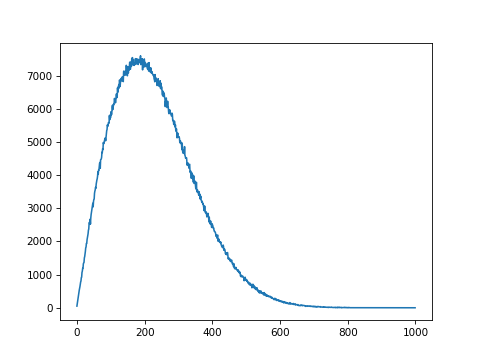

In [117]:
print(np.mean(shots_all_dark * np.conj(shots_all_dark)))
print(np.mean(np.sort(np.abs(shots_all_dark)**2)))
fig, ax = plt.subplots()
ax.plot(range(1000), np.histogram(np.abs(shots_all_dark), bins=1000)[0])

In [251]:
max_x = 8.5
mesh_size = 0.5
number_of_noise_photons = 0

# Define the range of dimensions
dim =100

noise_state = qutip.thermal_dm(dim, number_of_noise_photons)

s = time.time()
noisy_povm, alphas, xs, ps = cst2.generate_coherent_state_POVM(max_x, 
                                                              mesh_size, 
                                                              dim,
                                                              cutoff=0)
e = time.time()
print('Constructing POVM took: ' + str(e - s) + str(' seconds'))

Constructing POVM took: 12.572853088378906 seconds


In [204]:
hist_2D_dark = np.histogram2d(np.real(shots_all_dark), np.imag(shots_all_dark), 
                                 range = [[xs[0] - mesh_size/2, xs[-1] + mesh_size/2],[ps[0] - mesh_size/2, ps[-1] + mesh_size/2]],
                                 bins = len(xs), density = True)[0]

su.average_over_histogram(hist_2D_dark, np.abs(alphas)**(2), mesh_size**2)

2.357072666666667

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


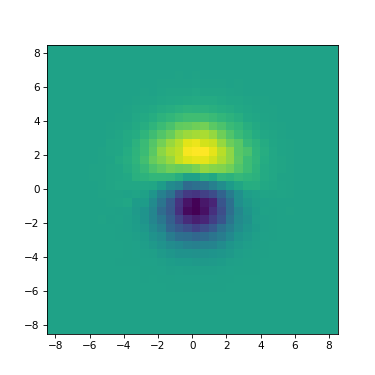

(35, 35)


In [252]:
hist_2D_dark = np.histogram2d(np.real(shots_all_dark), np.imag(shots_all_dark), 
                                 range = [[xs[0] - mesh_size/2, xs[-1] + mesh_size/2],[ps[0] - mesh_size/2, ps[-1] + mesh_size/2]],
                                 bins = len(xs), density = True)[0]

hist_2D = np.histogram2d(np.real(shots_all), np.imag(shots_all), 
                                 range = [[xs[0] - mesh_size/2, xs[-1] + mesh_size/2],[ps[0] - mesh_size/2, ps[-1] + mesh_size/2]],
                                 bins = len(xs), density = True)[0]
fig, ax = plt.subplots(figsize=(5, 5))
ax.pcolormesh(xs, ps, hist_2D - hist_2D_dark)
print(hist_2D_dark.shape)

In [115]:
su.average_over_histogram(hist_2D_dark, np.abs(alphas)**2, mesh_size**2) / 4.36


1.2472425275857435

<IPython.core.display.Javascript object>


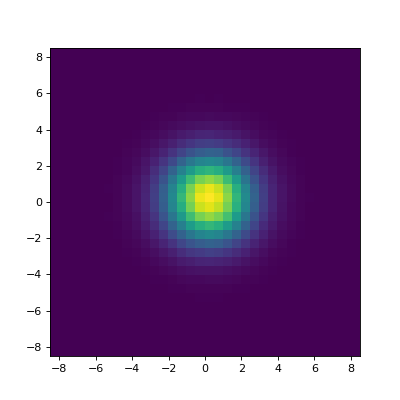

4.0


In [68]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.pcolormesh(xs, ps, hist_2D_dark)
print(np.sum(hist_2D_dark))

In [253]:
# Perform ideal coherent state POVM MLE
number_of_mle_iterations = 200
s = time.time()
reconstructed_superposition_state, lls = \
    cst2.perform_coherent_state_MLE(
        noisy_povm,
        hist_2D_dark, 
        number_of_mle_iterations,
        frequency_threshold=0,
        cutoff=0,
        identity_mixin=0)
e = time.time()
print('Time for MLE reconstruction for dim = ' + str(dim) + ': ' + str(e - s) + ' s')

Time for MLE reconstruction for dim = 100: 242.99674892425537 s


0.9999869939836219


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


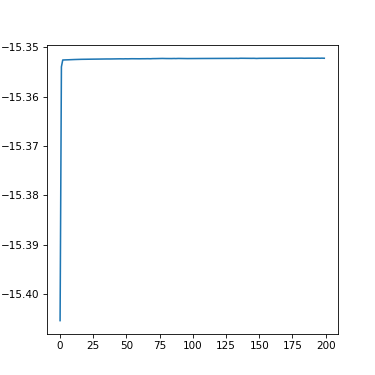

In [254]:
print(reconstructed_superposition_state.tr())
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(range(len(lls)), lls)

../../utils/tomography/coherent_state_tomography_copy.py:315: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, num_data_sets, figsize=(5*num_data_sets, 5))


<IPython.core.display.Javascript object>


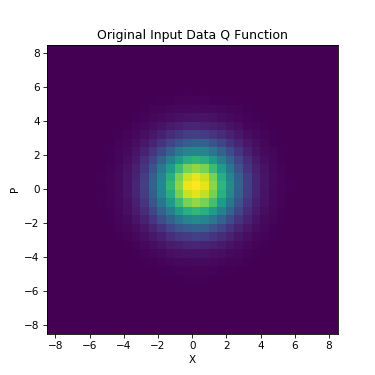

../../utils/tomography/coherent_state_tomography_copy.py:333: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, num_data_sets, figsize=(5*num_data_sets, 5))


<IPython.core.display.Javascript object>


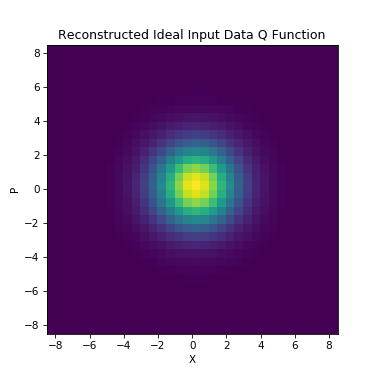

../../utils/visualization/state_visualization.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)


<IPython.core.display.Javascript object>


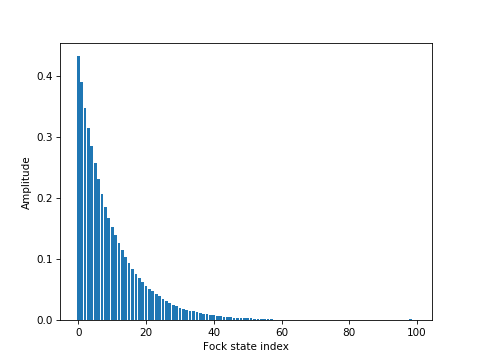

In [255]:
cst2.plot_coherent_state_tomography_Q_functions(hist_2D_dark,
                                               reconstructed_superposition_state,
                                               xs,
                                               ps)

../../utils/visualization/state_visualization.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)


<IPython.core.display.Javascript object>


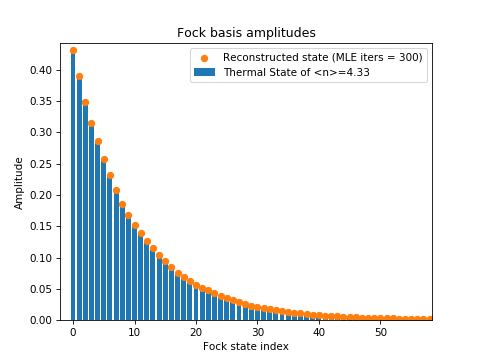

In [256]:
number_of_noise_photons = 4.33
# Define the range of dimensions
dim = 100
noise_state = qutip.thermal_dm(dim, number_of_noise_photons)
legend_labels = {'ref': 'Thermal State of <n>=4.33', 'data': 'Reconstructed state (MLE iters = 300)'}
state_vis.plot_fock_basis_amplitudes_with_reference(reconstructed_superposition_state,
                                                    noise_state,
                                                    legend_labels, 
                                                    title='Fock basis amplitudes')

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


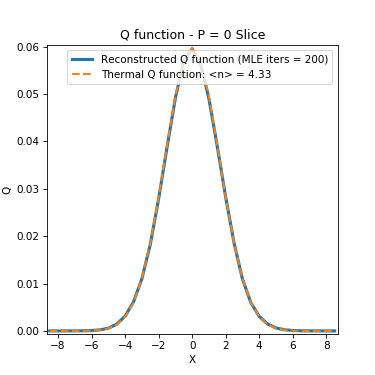

In [269]:
number_of_noise_photons = 4.33
noise_state = qutip.thermal_dm(dim, number_of_noise_photons)
noisy_qfunc = qutip.qfunc(noise_state, xs, ps, g=2)
reconstructed_qfunc = qutip.qfunc(reconstructed_superposition_state, xs, ps, g=2)

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(xs, reconstructed_qfunc[len(xs) // 2], linewidth=3, label='Reconstructed Q function (MLE iters = 200)')
ax.plot(xs, noisy_qfunc[len(xs) // 2], linestyle='dashed', linewidth=2, label='Thermal Q function: <n> = 4.33')
ax.set_xlabel('X')
ax.set_ylabel('Q')
ax.set_title('Q function - P = 0 Slice')
ax.legend()
ax.margins(0.01)

In [277]:
dim = 100
max_x = 8.5
mesh_size = 0.5
number_of_noise_photons = 4.36

reconstructed_dark_state = reconstructed_superposition_state
noise_state = reconstructed_dark_state
noise_state = qutip.thermal_dm(dim, number_of_noise_photons)

s = time.time()
noisy_povm, alphas, xs, ps = cst2.generate_coherent_state_POVM(max_x, 
                                                              mesh_size, 
                                                              dim,
                                                              noise_base=noise_state,
                                                              cutoff=0)
e = time.time()
print('Constructing POVM took: ' + str(e - s) + str(' seconds'))


Constructing POVM took: 17.685718059539795 seconds


In [230]:
povm_path = "/Users/andreas/Desktop/work/cluster_state/photon_tomography/povms/"
filename = 'dim_80_halfwidth_7p5_res_0p5_4p36_noise_photons.npz'
povm_savepath = os.path.join(povm_path, filename)
cst2.save_povm(povm_savepath, noisy_povm, alphas, xs, ps, noise_state)

povms, new_alphas, new_xs, new_ps, new_noise_state = cst2.load_povm(povm_savepath)

In [235]:
print(all(povms == noisy_povm))
print(np.array(reconstructed_dark_state).dtype)

True
complex128


In [232]:
iter_path = "/Users/andreas/Desktop/work/cluster_state/photon_tomography/reconstruction_checkpoints/"
filename = 'test.npz'
iter_savepath = os.path.join(povm_path, filename)
iter_range = [0, 100]
rho0 = qutip.maximally_mixed_dm(dim)
cst2.save_reconstruction_iteration(iter_savepath,
                                   reconstructed_dark_state,
                                   hist_2D_dark,
                                   lls,
                                   alphas,
                                   xs,
                                   ps,
                                   iter_range,
                                   rho0,
                                   povm_savepath)

s, h, l, a, x, p, ir, r0, pp = cst2.load_reconstruction_iteration(savepath)

/Users/andreas/Desktop/work/cluster_state/photon_tomography/povms/dim_80_halfwidth_7p5_res_0p5_4p36_noise_photons.npz


In [233]:
print(all(pp == noisy_povm))

True


In [229]:
print(len(pp))
print(len(noisy_povm))

31
35


In [278]:
# Perform ideal coherent state POVM MLE
number_of_mle_iterations = 300
s = time.time()
reconstructed_signal_state, lls_signal = \
    cst2.perform_coherent_state_MLE(
        noisy_povm,
        hist_2D, 
        number_of_mle_iterations,
        frequency_threshold=0,
        cutoff=0,
        identity_mixin=0)
e = time.time()
print('Time for MLE reconstruction for dim = ' + str(dim) + ': ' + str(e - s) + ' s')

Time for MLE reconstruction for dim = 100: 224.39595007896423 s


0.9999869939836219


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


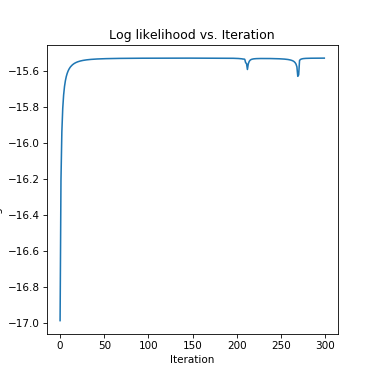

Text(0.5, 1.0, 'Log likelihood vs. Iteration')

In [279]:
print(reconstructed_superposition_state.tr())
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(range(len(lls_signal)), lls_signal)
ax.set_xlabel('Iteration')
ax.set_ylabel('Log likelihood')
ax.set_title('Log likelihood vs. Iteration')

35


../../utils/tomography/coherent_state_tomography_copy.py:315: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, num_data_sets, figsize=(5*num_data_sets, 5))


<IPython.core.display.Javascript object>


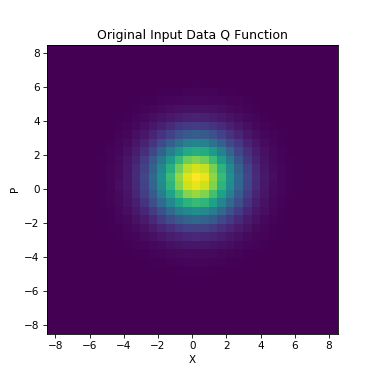

../../utils/tomography/coherent_state_tomography_copy.py:333: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, num_data_sets, figsize=(5*num_data_sets, 5))


<IPython.core.display.Javascript object>


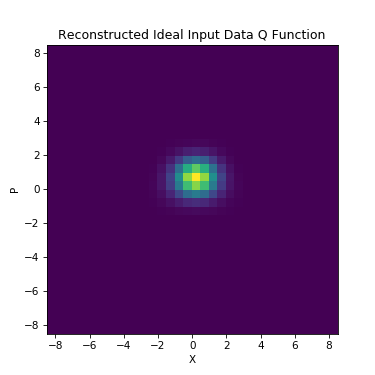

../../utils/visualization/state_visualization.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)


<IPython.core.display.Javascript object>


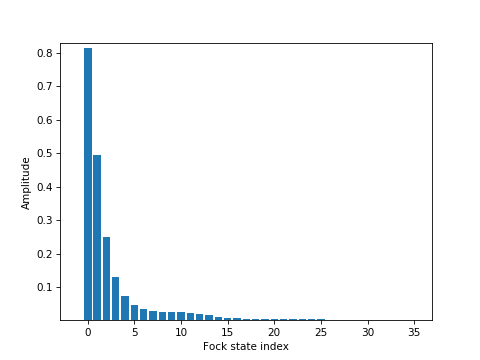

In [272]:
print(len(hist_2D_dark))
cst2.plot_coherent_state_tomography_Q_functions(hist_2D,
                                               reconstructed_signal_state,
                                               xs,
                                               ps)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


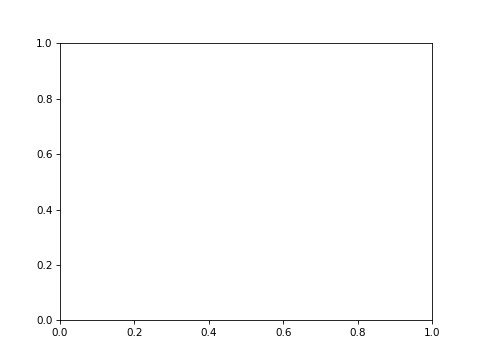

<IPython.core.display.Javascript object>


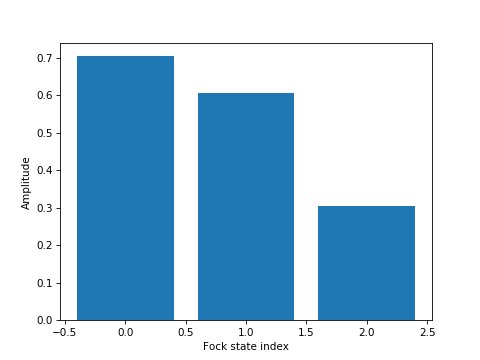

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


<IPython.core.display.Javascript object>


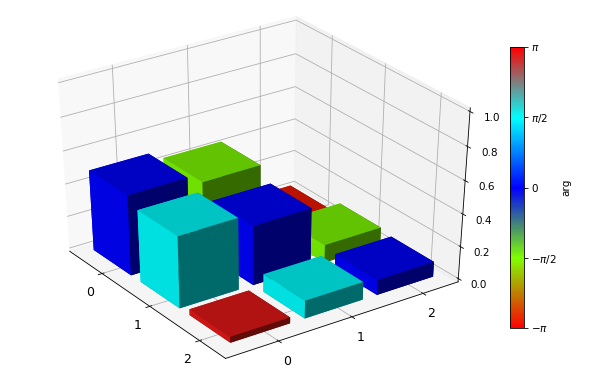

(<Figure size 800x500 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x1a2e7319d0>)

In [275]:
restricted_rho = qutip.Qobj(np.array(reconstructed_signal_state)[:3, :3])
loss_scaling = 0.6665061576492075
restricted_rho = (restricted_rho - (1- loss_scaling) * np.array([[1,0,0],[0,0,0],[0,0,0]]))/loss_scaling
fig, ax = plt.subplots()
state_vis.plot_fock_basis_amplitudes(restricted_rho)

fig = plt.figure( figsize=(8,5) )
ax = Axes3D(fig, azim=-35, elev=35)

qutip.matrix_histogram_complex(qutip.Qobj(restricted_rho), fig=fig, ax=ax) 

<IPython.core.display.Javascript object>


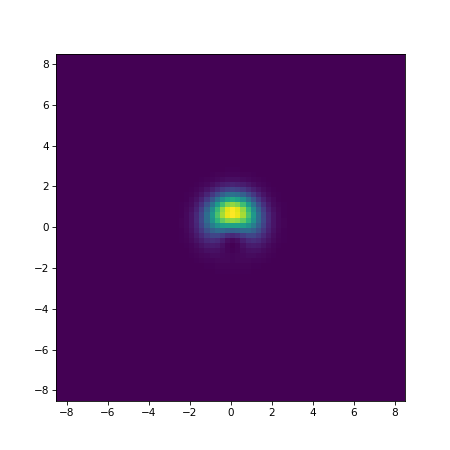

In [134]:
dim = 100
state = (qutip.basis(dim, 0) + 1j*qutip.basis(dim, 1)).unit()
rho = state * state.dag()

qfunc = qutip.qfunc(state, xs, ps, g=2)
fig, ax = plt.subplots(figsize = (6, 6))
ax.pcolormesh(xs, ps, qfunc)

In [135]:
a = qutip.destroy(5)

In [136]:
a.pow(4)

AttributeError: 'Qobj' object has no attribute 'pow'

In [140]:
pow(a, 4)

Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = False
Qobj data =
[[0.         0.         0.         0.         4.89897949]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]

In [153]:
state = (qutip.basis(10, 0) + 1j*qutip.basis(10, 1)).unit()
moments = qou.compute_matrix_of_moments(state, 3)

<IPython.core.display.Javascript object>


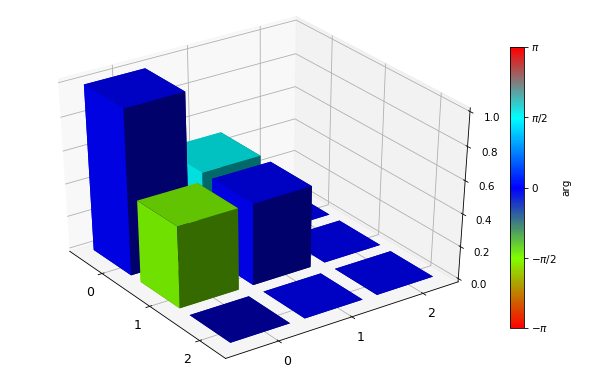

(<Figure size 800x500 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x1a2608d650>)

In [154]:
moments = qou.compute_matrix_of_moments(state, 3)
fig = plt.figure( figsize=(8,5) )
ax = Axes3D(fig, azim=-35, elev=35)
qutip.matrix_histogram_complex(qutip.Qobj(moments), fig=fig, ax=ax) 